# Masking data
---

In case of implicit filtering there's difficulty to run filtering only for a selected part of the data.
Here is a demonstration how this can be done.

In this example synthetic data on triangular mesh is used

In [1]:
import numpy as np
import math
# Mesh size
Lx = 1000
Ly = Lx
# Mesh resolution
dxm = 10
dym = dxm
cyclic = 0  # 1

### Create mesh

In [2]:
### Create mesh
xx = np.arange(0, Lx + 1, dxm)
yy = np.arange(0, Ly + 1, dym)

nx = len(xx)
ny = len(yy)

nodnum = np.arange(0, nx * ny)
xcoord = np.zeros((ny, nx))
ycoord = xcoord.copy()

for i in range(nx):
    ycoord[i, :] = yy

for i in range(ny):
    xcoord[:, i] = xx

### Create synthetic data with given spectra slope

In [3]:
tt = 50 * (np.random.random(xcoord.shape) - 0.5)
ttf = np.fft.fft2(tt)
# ============
# Make spectrum red
# ============
espectrum = np.zeros((nx // 2 + 1))  # Place for Fourier spectrum
kk = np.concatenate((np.arange(0, nx // 2 + 1), np.arange(-nx // 2 + 1, 0, 1)))  # Wavenumbers

for mx in range(nx):
    for my in range(ny):
        ll = np.sqrt(kk[my] * kk[my] + kk[mx] * kk[mx])  # Absolute value
        if my == 0 and mx == 0:  # Remove area mean
            ttf[my, mx] = 0.0
        else:  # Adjust amplitudes
            tmp = ttf[my, mx] / (np.power(ll, 1.5))  # 1.5 for -2 spectrum
            ttf[my, mx] = tmp
        if ll + 1 <= nx // 2 + 1:
            espectrum[np.floor(ll).astype(int)] += ttf[my, mx] * np.conj(ttf[my, mx])

espectrum = espectrum / np.power(nx, 4)

tt = np.real(np.fft.ifft2(ttf))  # We expect that it will show - 2 spectrum

/var/folders/p7/__mkfjf91fd70x4d4rzgvsq0rx9_k9/T/ipykernel_96757/2588423314.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  espectrum[np.floor(ll).astype(int)] += ttf[my, mx] * np.conj(ttf[my, mx])


### Reshape arrays and make triangulation

In [4]:
from implicit_filter import make_tri

nodnum = np.reshape(nodnum, [ny, nx]).T
xcoord = np.reshape(xcoord, [nx * ny])
ycoord = np.reshape(ycoord, [nx * ny])
tt = np.reshape(tt, [nx * ny])
tri = make_tri(nodnum, nx, ny) # Creates triangulation
n2d = len(xcoord)  # The number of vertices (nodes)
e2d = len(tri[:, 1]) # Number of elements (cells)

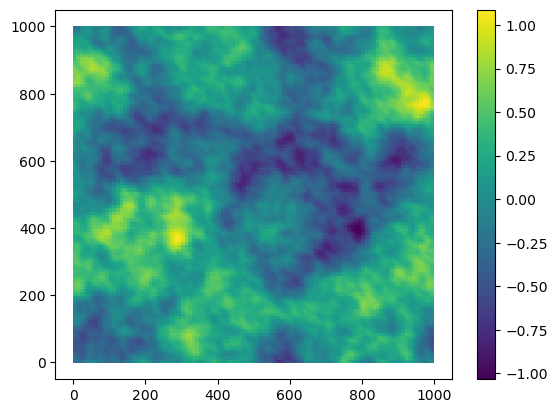

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

triangulation = mpl.tri.Triangulation(xcoord, ycoord, tri)

plt.tripcolor(triangulation, tt)
plt.colorbar()

Now part of this data needs to be masked (eg. land mask)

In [6]:
mask = np.logical_and(xcoord < 200, ycoord < 400)
masked_data = tt.copy()
masked_data[mask] = np.nan

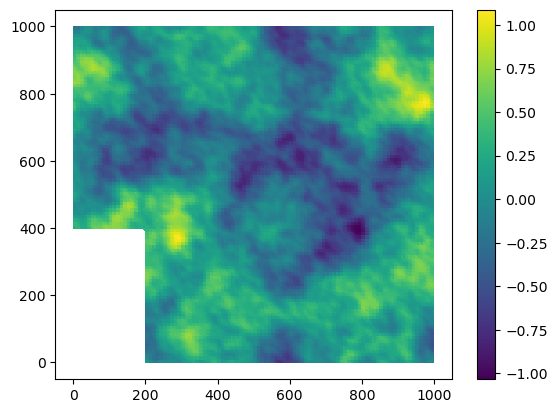

In [7]:
plt.tripcolor(triangulation, masked_data)
plt.colorbar()

### There are two way to handle such situation:

 1. Create filter specific for masked mesh
 2. Create filter for the whole mesh and fill unwanted data with neutreal value

### Solution 1: Mesh specific filter

Filter created with given mask is specific to this exact mask.
In case of any changes to the mask, new filter must be created

In [8]:
from implicit_filter import TriangularFilter

filter = TriangularFilter()
filter.prepare(n2d=n2d, e2d=e2d, tri=tri, xcoord=xcoord, ycoord=ycoord, mask=np.logical_not(mask))

In [9]:
tts = filter.compute(1, 2 * math.pi / 100., tt)

The part that wasn't filtered is clearly visible

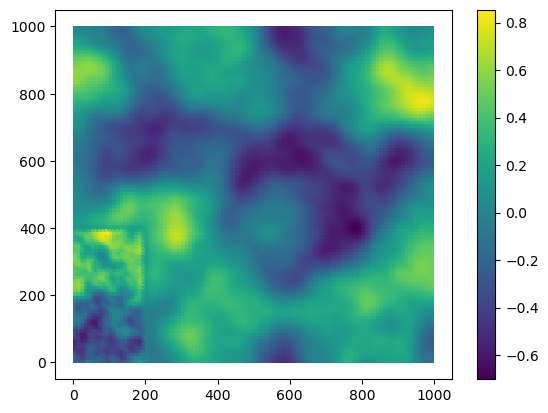

In [11]:
plt.tripcolor(triangulation, tts)
plt.colorbar()

It's even better visible when looking at the difference between filtered and original data

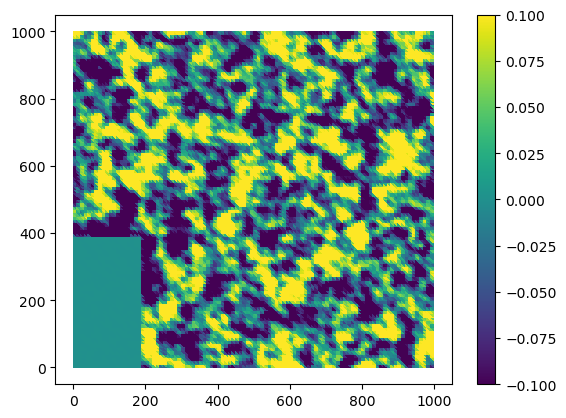

In [10]:
plt.tripcolor(triangulation, tts - tt, vmin=-0.1, vmax=0.1)
plt.colorbar()

### Solution 2: Filling with neutral value

The selected area should be filled with neutral value related to given variable.
Usually it's 0, but it might not work for all.

This method should be used with caution as results might different than expected.
Especially conservation laws might not be respected

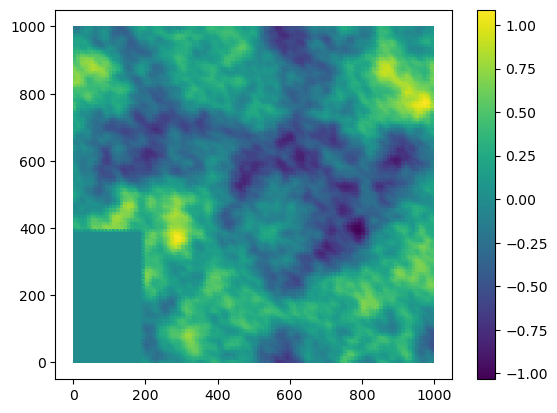

In [12]:
masked_data[mask] = 0.0

plt.tripcolor(triangulation, masked_data)
plt.colorbar()

In this solution, the filter for the entire mesh can be used all the time.

In [13]:
from implicit_filter import TriangularFilter

filter = TriangularFilter()
filter.prepare(n2d=n2d, e2d=e2d, tri=tri, xcoord=xcoord, ycoord=ycoord)

In [18]:
tts = filter.compute(1, 2 * math.pi / 100., masked_data)
tts[mask] = 0.0 # Reapply mask for the filtered data

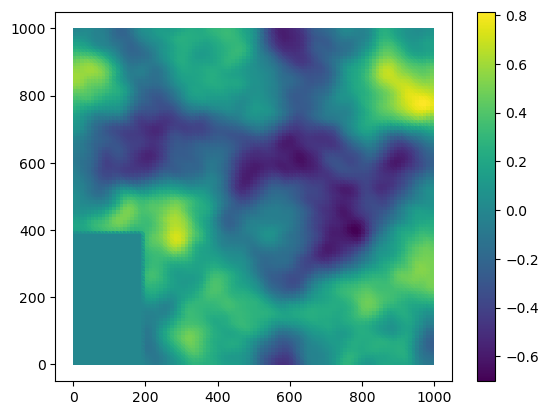

In [19]:
plt.tripcolor(triangulation, tts)
plt.colorbar()

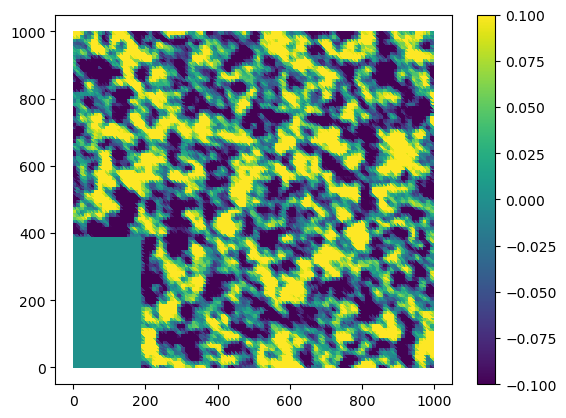

In [20]:
plt.tripcolor(triangulation, tts - masked_data, vmin=-0.1, vmax=0.1)
plt.colorbar()


## Extracting spectra

Regardless of the used method extracting spectra looks the same

In [25]:
kc = np.array([2, 4, 6, 8, 10, 12, 16, 20, 24, 30, 40, 60, 80, 100, 200]) * dxm
kc = 2 * math.pi / kc  # Wavenumbers

In [26]:
spectra = filter.compute_spectra_scalar(1, kc, tt, mask=mask)

Text(0, 0.5, '$ \\bar E $')

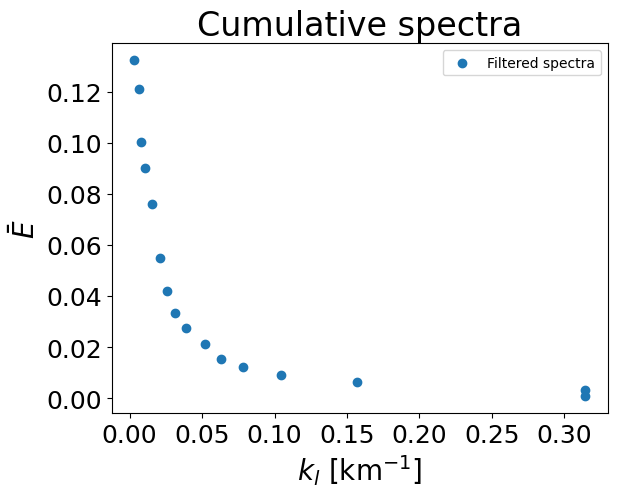

In [27]:
# Add the first element as spectra also contains value for unfiltered data on position 0
k = np.insert(kc, 0, kc[0])
plt.scatter(k, spectra, label="Filtered spectra")
plt.title("Cumulative spectra", fontsize=24)
plt.legend()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$k_l$ [km$^{-1}$]", fontsize=20)
plt.ylabel(r"$ \bar E $", fontsize=20)